In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FOLDER = 'E:/diss/reuters/'

In [3]:
df = pd.read_csv(FOLDER + "reuters_accs.csv")

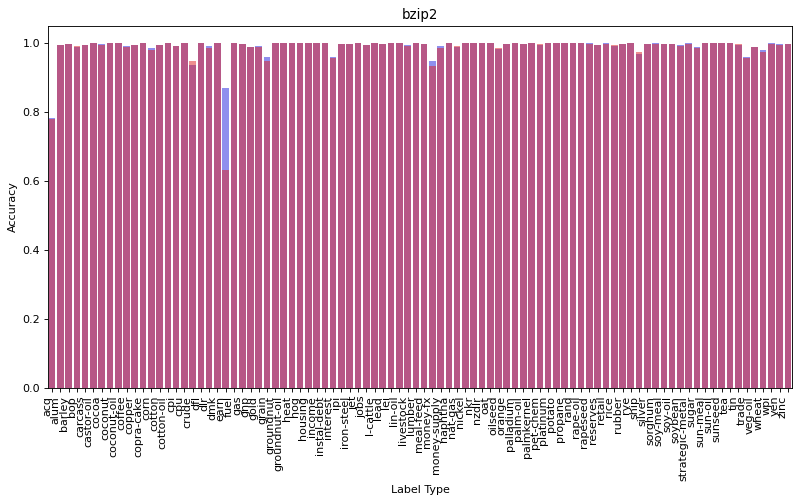

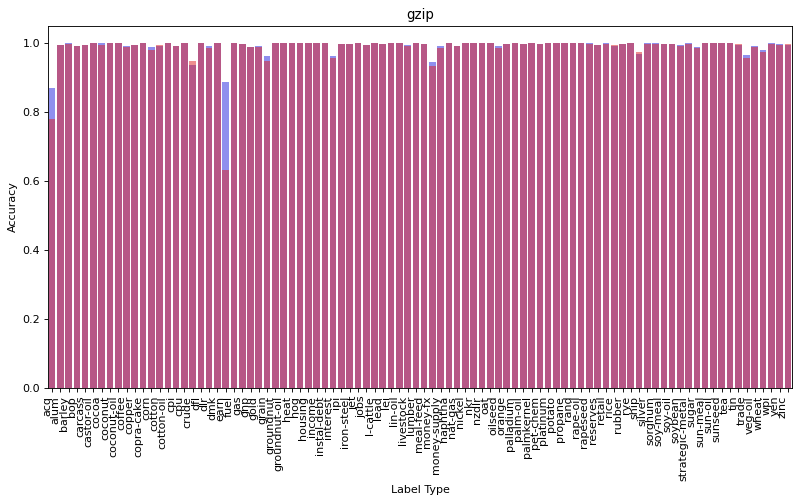

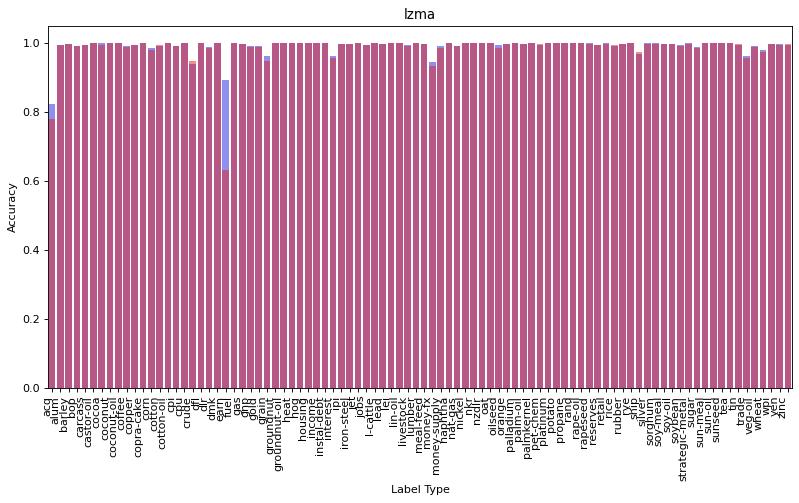

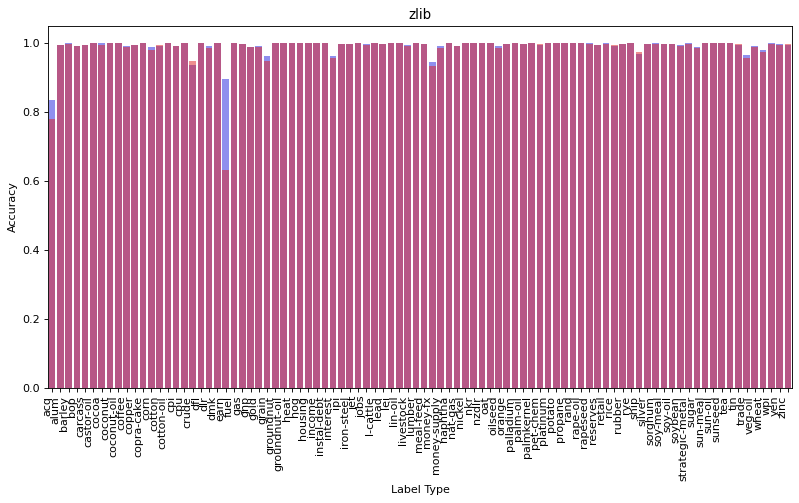

In [18]:
for compname in df["compname"].unique():
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
    sns.barplot(data=df[df["compname"] == compname], x="lbltype_name", y="val_acc", ax=ax, color='b', alpha=0.5)
    sns.barplot(data=df[df["compname"] == compname], x="lbltype_name", y="modal_acc", ax=ax, color='r', alpha=0.5)
    ax.set_xlabel('Label Type')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_title(compname)
    plt.show()

In [4]:
df = pd.read_csv(FOLDER + "reuters_cuts.csv")
df_val = df[df['seqpart'] == 1]
df_test = df[df['seqpart'] == 2]

In [5]:
df_val[df_val['emp_prob'] < 0.05]["lbltype_name"].unique()

array(['lead', 'wheat'], dtype=object)

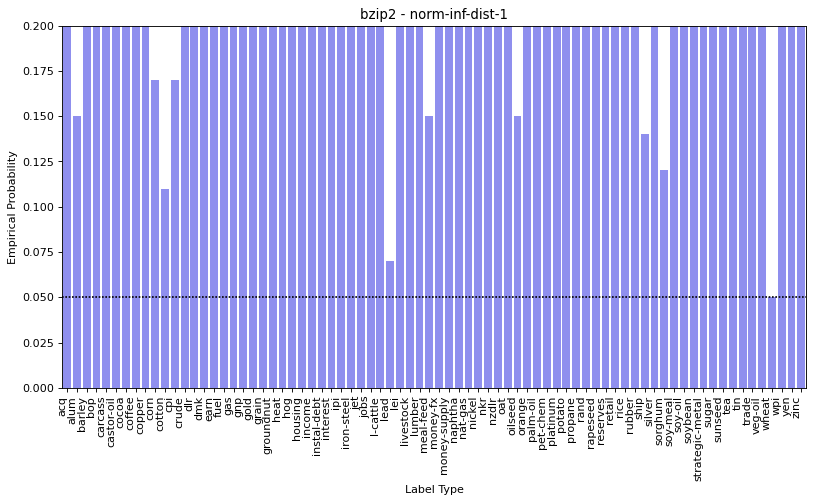

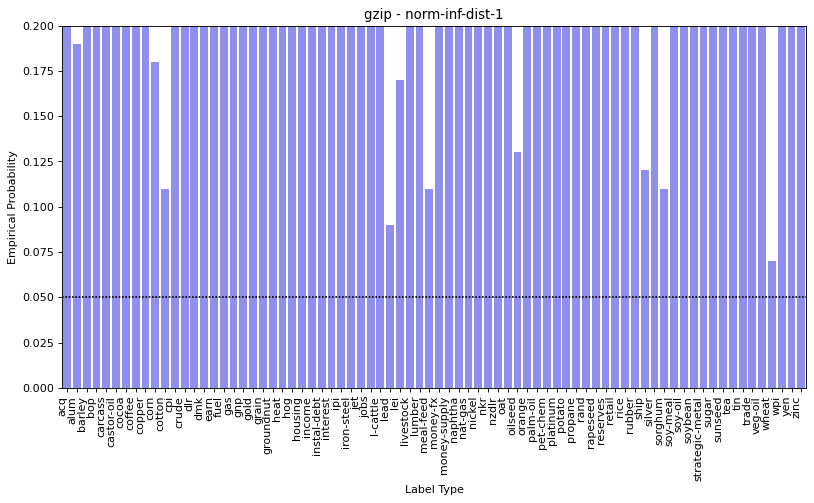

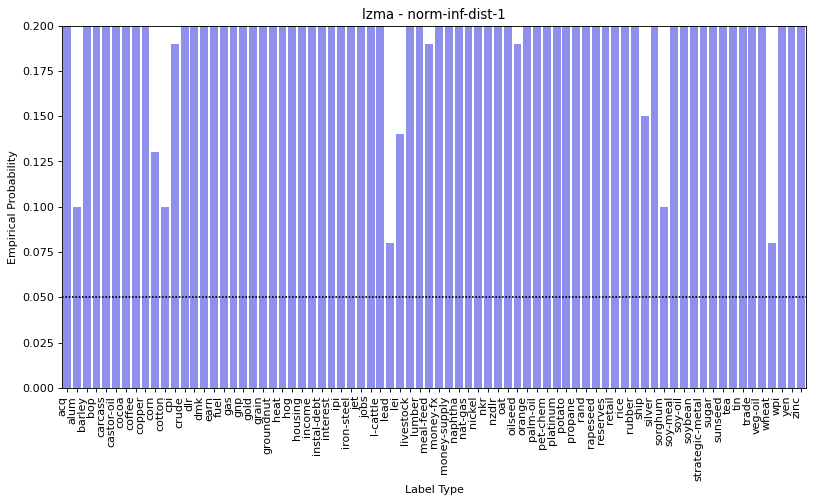

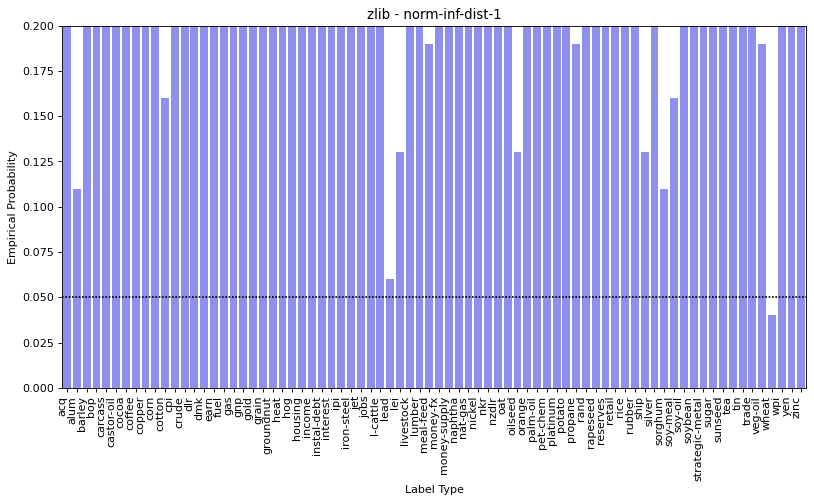

In [7]:
for compname in df_val['compname'].unique():
    ncd_formula = 'norm-inf-dist-1'
    plt.gcf().set_size_inches((12, 6))
    plt.gcf().set_dpi(80)
    plt.ylim((0.0, 0.2))
    sns.barplot(data=df_val[(df_val["compname"] == compname) & (df_val["ncd_formula"] == ncd_formula)
                            & pd.notnull(df_val["emp_prob"])],
                x="lbltype_name", y="emp_prob", color='b', alpha=0.5)
    #sns.barplot(data=df_test[(df_test["compname"] == compname) & (df_test["ncd_formula"] == ncd_formula)],
    #            x="lbltype_name", y="emp_prob", color='r', alpha=0.5)
    plt.axhline(y=0.05, color='black', dashes=(1, 1))
    plt.xlabel('Label Type')
    plt.ylabel('Empirical Probability')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='right')
    plt.title(compname + " - " + ncd_formula)
    plt.show()